<a href="https://colab.research.google.com/github/nitinranjansharma/EVA5B2/blob/main/s6/EVA4_S5F9_FinalRun.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [ ]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                       transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-9.0, 9.0), fill=(1,)),
                                       #transforms.CenterCrop(24),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      # transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [ ]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# Dataloader Arguments & Test/Train Dataloaders


In [ ]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


In [ ]:
print(len(train_loader.dataset))
print(len(test_loader.dataset))
print((60000/128)*15)

60000
10000
7031.25


# The model
Let's start with the model we first saw

In [ ]:
import torch.nn.functional as F
dropout_value = 0.1
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10),
            #nn.Dropout(dropout_value)
        ) # output_size = 26 ,Reseptive Field 3

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            #nn.Dropout(dropout_value)
        ) # output_size = 24 ,Reseptive Field 5

        # TRANSITION BLOCK 1

        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12 ,Reseptive Field 6

        ## RES block 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU(),
            #nn.Dropout(dropout_value)
        ) # output_size = 12 ,Reseptive Field 6

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(10),
            #nn.Dropout(dropout_value)
        ) # output_size = 10,Reseptive Field 10

        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=32, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            #nn.Dropout(dropout_value)
        ) # output_size = 10, ,Reseptive Field 10

        #RES Block 2
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(10),
            #nn.Dropout(dropout_value)
        ) # output_size = 10 ,Reseptive Field 10

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(10),
            #nn.Dropout(dropout_value)
        ) # output_size = 8,Reseptive Field 14

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=32, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            #nn.Dropout(dropout_value)
        ) # output_size = 8 ,Reseptive Field 14

        #RES Block 3
        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(10),
            #nn.Dropout(dropout_value)
        ) # output_size = 8,Reseptive Field 14

        self.convblock10 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=14, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(14),
            #nn.Dropout(dropout_value)
        ) # output_size = 6,Reseptive Field 18

        self.convblock11 = nn.Sequential(
            nn.Conv2d(in_channels=14, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            #nn.Dropout(dropout_value)
        ) # output_size = 4,Reseptive Field 22
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=4)
        ) # output_size = 1, Reseptive Field 28

        self.convblock12 = nn.Sequential(
              nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        ) # output_size = 1, Reseptive Field 28


        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        #x = self.pool2(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = self.convblock9(x)
        x = self.convblock10(x)
        x = self.convblock11(x)
        x = self.gap(x)        
        x = self.convblock12(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)




In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
              ReLU-2           [-1, 10, 26, 26]               0
       BatchNorm2d-3           [-1, 10, 26, 26]              20
            Conv2d-4           [-1, 16, 24, 24]           1,440
              ReLU-5           [-1, 16, 24, 24]               0
       BatchNorm2d-6           [-1, 16, 24, 24]              32
            Conv2d-7           [-1, 10, 24, 24]             160
       BatchNorm2d-8           [-1, 10, 24, 24]              20
              ReLU-9           [-1, 10, 24, 24]               0
        MaxPool2d-10           [-1, 10, 12, 12]               0
           Conv2d-11           [-1, 10, 10, 10]             900
             ReLU-12           [-1, 10, 10, 10]               0
      BatchNorm2d-13           [-1, 10, 10, 10]              20
           Conv2d-14           [-1

In [ ]:
class BatchNorm(nn.BatchNorm2d):
    def __init__(self, num_features, eps=1e-05, momentum=0.1, weight=False, bias=False):
        super().__init__(num_features, eps=eps, momentum=momentum)
        self.weight.data.fill_(1.0)
        self.bias.data.fill_(0.0)
        self.weight.requires_grad = weight
        self.bias.requires_grad = bias


class GhostBatchNorm(BatchNorm):
    def __init__(self, num_features, num_splits, **kw):
        super().__init__(num_features, **kw)
        self.num_splits = num_splits
        self.register_buffer('running_mean', torch.zeros(num_features * self.num_splits))
        self.register_buffer('running_var', torch.ones(num_features * self.num_splits))

    def train(self, mode=True):
        if (self.training is True) and (mode is False):  # lazily collate stats when we are going to use them
            self.running_mean = torch.mean(self.running_mean.view(self.num_splits, self.num_features), dim=0).repeat(
                self.num_splits)
            self.running_var = torch.mean(self.running_var.view(self.num_splits, self.num_features), dim=0).repeat(
                self.num_splits)
        return super().train(mode)

    def forward(self, input):
        N, C, H, W = input.shape
        if self.training or not self.track_running_stats:
            return F.batch_norm(
                input.view(-1, C * self.num_splits, H, W), self.running_mean, self.running_var,
                self.weight.repeat(self.num_splits), self.bias.repeat(self.num_splits),
                True, self.momentum, self.eps).view(N, C, H, W)
        else:
            return F.batch_norm(
                input, self.running_mean[:self.num_features], self.running_var[:self.num_features],
                self.weight, self.bias, False, self.momentum, self.eps)

In [ ]:
import torch.nn.functional as F
dropout_value = 0.1
class Net_ghost(nn.Module):
    def __init__(self):
        super(Net_ghost, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            GhostBatchNorm(10,num_splits=2),
            nn.ReLU(),
            
            #nn.Dropout(dropout_value)
        ) # output_size = 26 ,Reseptive Field 3

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            GhostBatchNorm(16,num_splits=2),
            nn.ReLU(),
            
            #nn.Dropout(dropout_value)
        ) # output_size = 24 ,Reseptive Field 5

        # TRANSITION BLOCK 1

        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12 ,Reseptive Field 6

        ## RES block 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            GhostBatchNorm(10,num_splits=2),
            nn.ReLU(),
            #nn.Dropout(dropout_value)
        ) # output_size = 12 ,Reseptive Field 6

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            GhostBatchNorm(10,num_splits=2),
            nn.ReLU(),            
            #nn.Dropout(dropout_value)
        ) # output_size = 10,Reseptive Field 10

        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=32, kernel_size=(1, 1), padding=0, bias=False),
            GhostBatchNorm(32,num_splits=2),
            nn.ReLU(),
            #nn.Dropout(dropout_value)
        ) # output_size = 10, ,Reseptive Field 10

        #RES Block 2
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            GhostBatchNorm(10,num_splits=2),
            nn.ReLU(),            
            #nn.Dropout(dropout_value)
        ) # output_size = 10 ,Reseptive Field 10

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            GhostBatchNorm(10,num_splits=2),
            nn.ReLU()
            #nn.Dropout(dropout_value)
        ) # output_size = 8,Reseptive Field 14

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=32, kernel_size=(1, 1), padding=0, bias=False),
            GhostBatchNorm(32,num_splits=2),
            nn.ReLU(),
            #nn.Dropout(dropout_value)
        ) # output_size = 8 ,Reseptive Field 14

        #RES Block 3
        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            GhostBatchNorm(10,num_splits=2),
            nn.ReLU(),          
            #nn.Dropout(dropout_value)
        ) # output_size = 8,Reseptive Field 14

        self.convblock10 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=14, kernel_size=(3, 3), padding=0, bias=False),
            GhostBatchNorm(14,num_splits=2),
            nn.ReLU(),            
            #nn.Dropout(dropout_value)
        ) # output_size = 6,Reseptive Field 18

        self.convblock11 = nn.Sequential(
            nn.Conv2d(in_channels=14, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            GhostBatchNorm(16,num_splits=2),
            nn.ReLU(),            
            #nn.Dropout(dropout_value)
        ) # output_size = 4,Reseptive Field 22
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=4)
        ) # output_size = 1, Reseptive Field 28

        self.convblock12 = nn.Sequential(
              nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        ) # output_size = 1, Reseptive Field 28


        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        #x = self.pool2(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = self.convblock9(x)
        x = self.convblock10(x)
        x = self.convblock11(x)
        x = self.gap(x)        
        x = self.convblock12(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [ ]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model2 = Net_ghost().to(device)
summary(model2, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
    GhostBatchNorm-2           [-1, 10, 26, 26]              20
              ReLU-3           [-1, 10, 26, 26]               0
            Conv2d-4           [-1, 16, 24, 24]           1,440
    GhostBatchNorm-5           [-1, 16, 24, 24]              32
              ReLU-6           [-1, 16, 24, 24]               0
            Conv2d-7           [-1, 10, 24, 24]             160
    GhostBatchNorm-8           [-1, 10, 24, 24]              20
              ReLU-9           [-1, 10, 24, 24]               0
        MaxPool2d-10           [-1, 10, 12, 12]               0
           Conv2d-11           [-1, 10, 10, 10]             900
   GhostBatchNorm-12           [-1, 10, 10, 10]              20
             ReLU-13           [-1, 10, 10, 10]               0
           Conv2d-14           [-1

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [ ]:
from tqdm import tqdm

def train(train_losses,train_acc,model, device, train_loader, optimizer, epoch,l1=0,lambda1 = 10e-4 ,NeedL1=True,):
  

  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    if NeedL1 == True:  
      loss = F.nll_loss(y_pred, target)
      l1 = 0
      for p in model.parameters():
        l1=l1+p.abs().sum()
      loss = loss+lambda1*l1
    else:
      loss = F.nll_loss(y_pred, target)

    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)
    #return train_losses,train_acc

def test(test_losses,test_acc,model, device, test_loader):

    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

    #return test_losses,test_acc

In [ ]:
#for model with two resnet block 
from torch.optim.lr_scheduler import StepLR
def training_loop(model,l1=0,lambda1 = 10e-4 ,NeedL1=True,EPOCHS = 25 ,weight_decay =0,device=device,train_loader=train_loader,saveM=True):
  train_losses1 = []
  train_acc1 = []
  test_losses1 = []
  test_acc1 = []
  train_losses = []
  train_acc = []
  test_losses = []
  test_acc = []
  #model =  Net().to(device)
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9,weight_decay = weight_decay)
  scheduler = StepLR(optimizer, step_size=6, gamma=0.5)
  for epoch in range(EPOCHS):
      print("EPOCH:", epoch)
      train(train_losses, train_acc, model, device, train_loader, optimizer, epoch,l1=0,lambda1 = 10e-4 ,NeedL1=NeedL1)
      scheduler.step()
      print('current Learing Rate: ', optimizer.state_dict()["param_groups"][0]["lr"])
      test(test_losses,test_acc,model, device, test_loader)
      #train_losses1.append(train_losses)
      #train_acc1.append(train_acc)
      #test_losses1.append(test_losses)
      #test_acc1.append(test_acc)
  return train_losses,test_losses,train_acc,test_acc, model 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def training_fun(EPOCHS = 25):
  final = {}
  final['Model1'] = {}
  final['Model2'] = {}
  final['Model3'] = {}
  final['Model4'] = {}
  final['Model5'] = {} 
  
  #Model Type 1
  model =  Net().to(device)
  train_losses_l1,test_losses_l1,train_acc_l1,test_acc_l1,model = training_loop(model = model,l1=0,lambda1 = 10e-4 ,NeedL1=True,EPOCHS = EPOCHS ,weight_decay =0,device=device,train_loader=train_loader)
  #torch.save(model.state_dict(), '/content/drive/MyDrive/EVA4S6/checkpoint_type1.pth')
  
  #Model Type 2
  model =  Net().to(device)  
  train_losses_l2,test_losses_l2,train_acc_l2,test_acc_l2,model = training_loop(model = model,l1=0,lambda1 = 10e-4 ,NeedL1=False,EPOCHS = EPOCHS ,weight_decay =1e-5,device=device,train_loader=train_loader)
  #torch.save(model.state_dict(), '/content/drive/MyDrive/EVA4S6/checkpoint_type2.pth')
  
  #Model Type 3
  model =  Net().to(device)
  train_losses_l12,test_losses_l12,train_acc_l12,test_acc_l12,model = training_loop(model = model,l1=0,lambda1 = 10e-4 ,NeedL1=True,EPOCHS = EPOCHS ,weight_decay =1e-5,device=device,train_loader=train_loader)
  #torch.save(model.state_dict(), '/content/drive/MyDrive/EVA4S6/checkpoint_type3.pth')

  #Model Type 4
  model2 = Net_ghost().to(device)  
  train_losses_GBN,test_losses_GBN,train_acc_GBN,test_acc_GBN, model = training_loop(model = model2,l1=0,lambda1 = 10e-4 ,NeedL1=False,EPOCHS = EPOCHS ,weight_decay =0,device=device,train_loader=train_loader)
  #torch.save(model.state_dict(), '/content/drive/MyDrive/EVA4S6/checkpoint_type4.pth')
  trained = model2
  #Model Type 5
  model2 = Net_ghost().to(device)   
  train_losses_GBN_1,test_losses_GBN_1,train_acc_GBN_1,test_acc_GBN_1,model = training_loop(model = model2,l1=0,lambda1 = 10e-4 ,NeedL1=True,EPOCHS = EPOCHS ,weight_decay =1e-5,device=device,train_loader=train_loader)
  #torch.save(model.state_dict(), '/content/drive/MyDrive/EVA4S6/checkpoint_type5.pth')
  
  final['Model1']['train_loss_l1'] = train_losses_l1
  final['Model1']['test_loss_l1'] = test_losses_l1
  final['Model1']['train_acc_l1'] = train_acc_l1
  final['Model1']['test_acc_l1'] = test_acc_l1
  final['Model2']['train_losses_l2'] = train_losses_l2
  final['Model2']['test_losses_l2'] = test_losses_l2
  final['Model2']['train_acc_l2'] = train_acc_l2
  final['Model2']['test_acc_l2'] = test_acc_l2
  final['Model3']['train_losses_l12'] = train_losses_l12
  final['Model3']['test_losses_l12'] = test_losses_l12
  final['Model3']['train_acc_l12'] = train_acc_l12
  final['Model3']['test_acc_l12'] = test_acc_l12
  final['Model4']['train_losses_GBN'] = train_losses_GBN
  final['Model4']['test_losses_GBN'] = test_losses_GBN
  final['Model4']['train_acc_GBN'] = train_acc_GBN
  final['Model4']['test_acc_GBN'] = test_acc_GBN
  final['Model5']['train_losses_GBN_1'] = train_losses_GBN_1
  final['Model5']['test_losses_GBN_1'] = test_losses_GBN_1
  final['Model5']['train_acc_GBN_1'] = train_acc_GBN_1
  final['Model5']['test_acc_GBN_1'] = test_acc_GBN_1

  return final,trained
  

In [ ]:
#final_dict,trained = training_fun()

In [ ]:
from IPython.utils import io

with io.capture_output() as captured:
    final_dict,trained = training_fun()

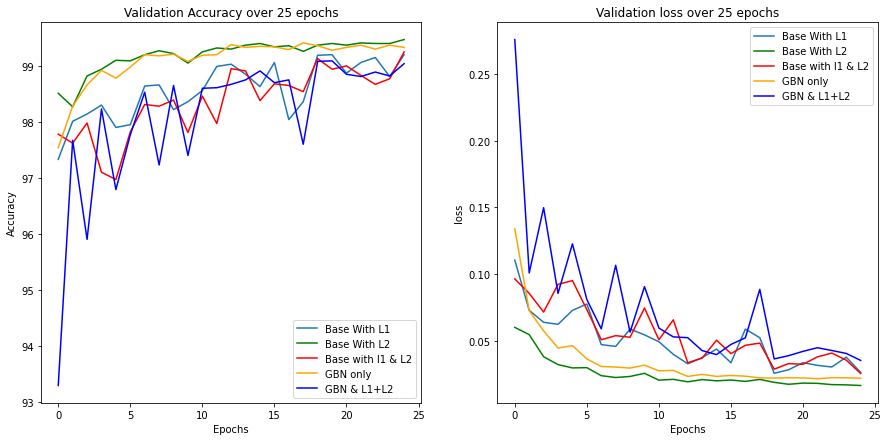

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,7))
ax1.plot(final_dict['Model1']['test_acc_l1'], label="Base With L1")
ax1.plot(final_dict['Model2']['test_acc_l2'], color="green", label="Base With L2")
ax1.plot(final_dict['Model3']['test_acc_l12'], color="red", label="Base with l1 & L2")
ax1.plot(final_dict['Model4']['test_acc_GBN'], color="orange", label="GBN only")
ax1.plot(final_dict['Model5']['test_acc_GBN_1'], color="blue", label="GBN & L1+L2")
ax1.set_title("Validation Accuracy over 25 epochs")
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()


ax2.plot(final_dict['Model1']['test_loss_l1'], label="Base With L1")
ax2.plot(final_dict['Model2']['test_losses_l2'], color="green", label="Base With L2")
ax2.plot(final_dict['Model3']['test_losses_l12'], color="red", label="Base with l1 & L2")
ax2.plot(final_dict['Model4']['test_losses_GBN'], color="orange", label="GBN only")
ax2.plot(final_dict['Model5']['test_losses_GBN_1'], color="blue", label="GBN & L1+L2")
ax2.set_title("Validation loss over 25 epochs")
ax2.set_xlabel('Epochs')
ax2.set_ylabel('loss')
ax2.legend()



In [ ]:
final_dict['Model1']['test_acc_l1']

[97.34,
 98.02,
 98.15,
 98.31,
 97.91,
 97.96,
 98.65,
 98.67,
 98.23,
 98.37,
 98.57,
 99.0,
 99.04,
 98.86,
 98.64,
 99.07,
 98.05,
 98.37,
 99.2,
 99.21,
 98.88,
 99.07,
 99.16,
 98.82,
 99.21]

In [ ]:
import numpy as np
from tqdm import tqdm
test_losses = []
test_acc = []
pred_wrong_t=[]
true_wrong_t=[]
image_t=[]


def test_misclassified(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    #pred1 = []
    #true = []
    pred_wrong = []
    true_wrong = []
    image = []


    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            
            
            preds = (pred.cuda()).cpu().numpy()
            target = (target.cuda()).cpu().numpy()

            preds = np.reshape(preds,(len(preds),1))
            target = np.reshape(target,(len(preds),1))

            data = (data.cuda()).cpu().numpy()

            for i in range(len(preds)):
                #pred1.append(preds[i])
                #true.append(target[i])

              if(preds[i]!=target[i]):
                pred_wrong.append(preds[i])
                true_wrong.append(target[i])
                image.append(data[i])

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    test_acc.append(100. * correct / len(test_loader.dataset))

    pred_wrong_t.extend(pred_wrong)
    true_wrong_t.extend(true_wrong)
    image_t.extend(image)

In [ ]:
#state_dict = torch.load('/content/drive/MyDrive/EVA4S6/checkpoint_type5.pth')
test_misclassified(trained, device, test_loader)


Test set: Average loss: 0.0222, Accuracy: 9934/10000 (99.34%)



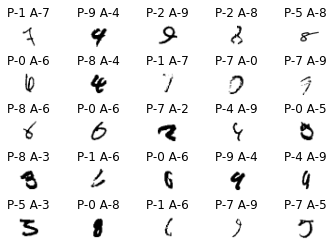

In [ ]:
from google.colab import files
import matplotlib.pyplot as plt
%matplotlib inline

figure = plt.figure()
num_of_images = 25
for index in range(1, num_of_images + 1):
    plt.subplot(5,5, index)
    plt.subplots_adjust(hspace=.9)
    plt.axis('off')
    plt.imshow(image_t[index].squeeze(), cmap='gray_r')
    a='P-'+str(int(pred_wrong_t[index]))+" A-"+str(int(true_wrong_t[index]))
    plt.title(a)
  
#figure.savefig('L2.png')
#files.download("L2.png")